In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

%matplotlib inline

In [2]:
np.set_printoptions(suppress=True)                 # prevent numpy to print in exponential form (scientific with e^x)

In [3]:
# manual input

# refPEEQ_file = 'compPEEQ_450um_middleStrip.csv'    # for waviness
# refPEEQ_file = 'compPEEQ_30um_middleStrip.csv'     # for roughness
refPEEQ_file = 'compPEEQ_300um_middleStrip.csv'    # temp used for waviness

timeStep_odb = 80

localPnt_no = 3                                    # amount of selected local point

In [4]:
# load data

# mises = pd.read_csv('mises.csv').values
peeq = pd.read_csv('peeq.csv').values
triax = pd.read_csv('triax.csv').values
lode = pd.read_csv('lode.csv').values
volume = pd.read_csv('volume.csv').values

**Initialize data**

In [5]:
# initialize component data

refPEEQ = np.genfromtxt(refPEEQ_file, delimiter=',', skip_header=1)

compTriax = [eta for [peeq, eta, theta] in refPEEQ]
compLode = [theta for [peeq, eta, theta] in refPEEQ]
compPeeq = [peeq for [peeq, eta, theta] in refPEEQ]

In [6]:
# initialize odb time frame data

timeStep = np.arange(1, timeStep_odb+1)

In [7]:
# DIL for 3D graph

c1 = 0.4
c2 = 1
c3 = 0.1
c4 = 1.5
c5 = 0.4
c6 = 1


# prepare x-point and y-point to cal in equation
data_pnts = 100

df_x = pd.DataFrame(np.zeros((2*data_pnts, 2*data_pnts)))
for i in range(2*data_pnts):
    df_x.iloc[i,:] = np.arange(-1, 1, 1/data_pnts)                      # row by rows
    
df_y = pd.DataFrame(np.zeros((2*data_pnts, 2*data_pnts)))
for i in range(2*data_pnts):
    df_y.iloc[:,i] = np.arange(-1, 1, 1/data_pnts)                      # column by columns


# construct DIL
df_DIL = ( c1*np.exp(-c2*df_x) - c3*np.exp(-c4*df_x) ) * df_y.pow(2) + c3*np.exp(-c4*df_x)

In [8]:
# DIL for 2D graph

## lode = 0.2 = constant
DILTriax = np.arange(-1.05, 1.05, 0.05)
ConstLode = np.ones(len(DILTriax)) * 0.2
DIL_constLode = ( c1*np.exp(-c2*DILTriax) - c3*np.exp(-c4*DILTriax) ) * np.power(ConstLode,2) + c3*np.exp(-c4*DILTriax)

## Triax = 0.2 = constant
DILLode = np.arange(-1.05, 1.05, 0.05)
ConstTriax = np.ones(len(DILLode)) * 0.2
DIL_constTriax = ( c1*np.exp(-c2*ConstTriax) - c3*np.exp(-c4*ConstTriax) ) * np.power(DILLode,2) + c3*np.exp(-c4*ConstTriax)

**Calculate global variables**

In [9]:
globalvolume = volume.sum(axis=1)
globalTriax = np.sum(triax * volume, axis=1)/globalvolume
globalLode = np.sum(lode * volume, axis=1)/globalvolume
globalPeeq = np.sum(peeq * volume, axis=1)/globalvolume

In [10]:
# prepare global dataframe

data_global = {'globalTriax': globalTriax, 'globalLode': globalLode, 'globalPeeq': globalPeeq} 
df_global = pd.DataFrame(data_global)


eta = globalTriax
theta = globalLode
DIL = ( c1*np.exp(-c2*eta) - c3*np.exp(-c4*eta) ) * np.power(theta,2) + c3*np.exp(-c4*eta)
df_global['globalDIL'] = np.around(DIL,3)


df_global['globalPEEQ > DIL'] = np.where(
    df_global['globalPeeq'] >= df_global['globalDIL'],
    1,
    0,
)


diffPeeq = np.diff(np.around(globalPeeq,4))
delPeeq = np.append(0, diffPeeq)
df_global['global-delPEEQ/DIL'] = delPeeq / DIL

delPeeqByDIL = df_global['global-delPEEQ/DIL'].values
df_global['global-DILaccu'] = np.cumsum(delPeeqByDIL)

df_global['global-DILaccu > 1'] = np.where(
    df_global['global-DILaccu'] >= 1.0,
    1,
    0,
)

df_global.head()

,globalTriax,globalLode,globalPeeq,globalDIL,globalPEEQ > DIL,global-delPEEQ/DIL,global-DILaccu,global-DILaccu > 1
0,-0.105302,0.030028,0.011783,0.117,0,0.0,0.0,0
1,-0.045644,0.034572,0.011815,0.107,0,0.0,0.0,0
2,-0.051600,0.003052,0.011817,0.108,0,0.0,0.0,0
3,0.005002,0.095014,0.011818,0.102,0,0.0,0.0,0
4,-0.059646,0.094768,0.011831,0.112,0,0.0,0.0,0


In [11]:
# find brokenStep

globalBrokenStep = 0

for i in range(timeStep_odb):
    if df_global.at[i,'global-DILaccu > 1'] == 1:
        globalBrokenStep = i+1
        break

print(globalBrokenStep)

29


In [12]:
df_global.to_csv('globalVar.csv', index=False)

In [13]:
# find first and last index for graph plot

df_global_plot = pd.DataFrame()

plot_start_i = 0
plot_end_i = timeStep_odb-1

for i in range(timeStep_odb):
    if df_global.at[i,'global-delPEEQ/DIL'] != 0:
        plot_start_i = i
        break
        
for i in range(timeStep_odb):
    if np.absolute(df_global.at[timeStep_odb-1-i,'globalTriax'] - df_global.at[timeStep_odb-2-i,'globalTriax']) < 0.005:
        plot_end_i = timeStep_odb-2-i
        break
        
df_global_plot = df_global.iloc[plot_start_i:plot_end_i]
        
print(plot_start_i)
print(plot_end_i)
df_global_plot.head()

5
75


,globalTriax,globalLode,globalPeeq,globalDIL,globalPEEQ > DIL,global-delPEEQ/DIL,global-DILaccu,global-DILaccu > 1
5,-0.047619,0.338189,0.011927,0.143,0,0.000699,0.000699,0
6,0.077711,0.394722,0.012199,0.133,0,0.002259,0.002958,0
7,0.073436,0.443058,0.012650,0.145,0,0.003450,0.006407,0
8,0.103240,0.449683,0.013470,0.141,0,0.005662,0.012070,0
9,0.130993,0.418540,0.014880,0.129,0,0.010833,0.022903,0


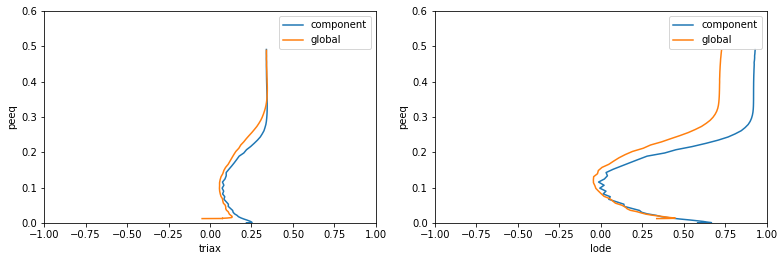

In [14]:
plot_size = (11, 4)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)

globalTriax = df_global_plot['globalTriax']
globalLode = df_global_plot['globalLode']
globalPeeq = df_global_plot['globalPeeq']

ax1.plot(compTriax, compPeeq, label='component')
ax1.plot(globalTriax, globalPeeq, label='global')
# ax1.plot(localTriax, localPeeq, label='local')
# ax1.plot(DILTriax, DIL_constLode, label='DIL')
ax1.set_xlim(-1, 1.0)
ax1.set_ylim(0, 0.6)
ax1.set(xlabel='triax', ylabel='peeq')
ax1.legend()

ax2.plot(compLode, compPeeq, label='component')
ax2.plot(globalLode, globalPeeq, label='global')
# ax2.plot(localLode, localPeeq, label='local')
# ax2.plot(DILLode, DIL_constTriax, label='DIL')
ax2.set_xlim(-1, 1)
ax2.set_ylim(0, 0.6)
ax2.set(xlabel='lode', ylabel='peeq')
ax2.legend()

plt.tight_layout()
f.subplots_adjust(top=0.88)

**Calculate local variables**

In [15]:
def calLocal(localElem_file):
    
    # initialize data
    
    localElems = np.loadtxt(localElem_file).tolist()
    localElems = [int(e) for e in localElems]

    localvolume = volume[:, localElems].sum(axis=1)
    localTriax = np.sum(triax[:, localElems] * volume[:, localElems], axis=1)/localvolume
    localLode = np.sum(lode[:, localElems] * volume[:, localElems], axis=1)/localvolume
    localPeeq = np.sum(peeq[:, localElems] * volume[:, localElems], axis=1)/localvolume
    
#-------------------------------------------------------------------------------------------------------------#

    # prepare local dataframe

    data_local = {'localTriax': localTriax, 'localLode': localLode, 'localPeeq': localPeeq} 
    df_local = pd.DataFrame(data_local)


    eta = localTriax
    theta = localLode
    DIL = ( c1*np.exp(-c2*eta) - c3*np.exp(-c4*eta) ) * np.power(theta,2) + c3*np.exp(-c4*eta)
    df_local['localDIL'] = np.around(DIL,3)


    df_local['localPEEQ > DIL'] = np.where(
        df_local['localPeeq'] >= df_local['localDIL'],
        1,
        0,
    )


    diffPeeq = np.diff(np.around(localPeeq,4))
    delPeeq = np.append(0, diffPeeq)
    df_local['local-delPEEQ/DIL'] = delPeeq / DIL

    delPeeqByDIL = df_local['local-delPEEQ/DIL'].values
    df_local['local-DILaccu'] = np.cumsum(delPeeqByDIL)

    df_local['local-DILaccu > 1'] = np.where(
        df_local['local-DILaccu'] >= 1.0,
        1,
        0,
    )

    df_local['surfFac'] = df_global['globalPeeq'] / df_local['localPeeq']
    
    return df_local

In [16]:
def surfFacLocal(df_local):
    
    # find brokenStep, surfFac
    localBrokenStep = 0
    surfFactor = 0
    brokenSeq = 'notDefined'

    for i in range(timeStep_odb):
        if df_local.at[i,'local-DILaccu > 1'] == 1:
            localBrokenStep = i+1
            surfFactor = df_local.at[i,'surfFac']
            break

    if localBrokenStep <= globalBrokenStep:
        brokenSeq = 'local breaks before'
    else:
        brokenSeq = 'global breaks before'

    print(brokenSeq)
    print(localBrokenStep)
    print(round(surfFactor,2))

    return brokenSeq, localBrokenStep, round(surfFactor,2)

In [17]:
def trimForPlot(df_local):
    
    # find first and last index for graph plot
    plot_start_i = 0
    plot_end_i = timeStep_odb-1

    for i in range(timeStep_odb):
        if df_local.at[i,'local-delPEEQ/DIL'] != 0:
            plot_start_i = i
            break

    for i in range(timeStep_odb):
        if np.absolute(df_local.at[timeStep_odb-1-i,'localTriax'] - df_local.at[timeStep_odb-2-i,'localTriax']) < 0.005:
            plot_end_i = timeStep_odb-2-i
            break

    df_local_plot = df_local.iloc[plot_start_i:plot_end_i]
    
    return df_local_plot

In [18]:
def graphPlot2D(df_global_plot, df_local_plot):

    # get data for graph
    globalTriax = df_global_plot['globalTriax']
    globalLode = df_global_plot['globalLode']
    globalPeeq = df_global_plot['globalPeeq']
    
    localTriax = df_local_plot['localTriax']
    localLode = df_local_plot['localLode']
    localPeeq = df_local_plot['localPeeq']
    
    plot_size = (11, 4)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=plot_size)

    # ax1.plot(compTriax, compPeeq, label='component')
    ax1.plot(globalTriax, globalPeeq, label='global')
    ax1.plot(localTriax, localPeeq, label='local')
#     ax1.plot(DILTriax, DIL_constLode, label='DIL')
    ax1.set_xlim(-1, 1.0)
    ax1.set_ylim(0, 0.6)
    ax1.set(xlabel='triax', ylabel='peeq')
    ax1.legend()

    # ax2.plot(compLode, compPeeq, label='component')
    ax2.plot(globalLode, globalPeeq, label='global')
    ax2.plot(localLode, localPeeq, label='local')
#     ax2.plot(DILLode, DIL_constTriax, label='DIL')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(0, 0.6)
    ax2.set(xlabel='lode', ylabel='peeq')
    ax2.legend()

    plt.tight_layout()
    f.subplots_adjust(top=0.88)

In [19]:
def graphPlot3D(df_global_plot, df_local_plot):

    # get data for graph
    globalTriax = df_global_plot['globalTriax']
    globalLode = df_global_plot['globalLode']
    globalPeeq = df_global_plot['globalPeeq']
    
    localTriax = df_local_plot['localTriax']
    localLode = df_local_plot['localLode']
    localPeeq = df_local_plot['localPeeq']
    
    # plot start
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot global scatter result    
    xs = globalTriax
    ys = globalLode
    zs = globalPeeq
    ax.plot(xs, ys, zs, label='global')

    # plot local scatter result    
    xs = localTriax
    ys = localLode
    zs = localPeeq
    localPlot = ax.plot(xs, ys, zs, label='local')

    # plot DIL
    X = np.arange(-1, 1, 0.01)
    Y = np.arange(-1, 1, 0.01)
    X, Y = np.meshgrid(X, Y)
    Z = df_DIL
    ax.plot_wireframe(X, Y, Z, label='DIL')

    # set axis label
    ax.set_xlabel('triax')
    ax.set_ylabel('lode')
    ax.set_zlabel('PEEQ')
    ax.legend()

    plt.show()

In [20]:
list_df_local = []

data_surfFac = {'timeFrame': timeStep} 
df_surfFac = pd.DataFrame(data_surfFac)

f = open('surfFac.txt', 'w')

print('global')
print(globalBrokenStep)
print('\n')
f.write('global' + '\n')
f.write('broken timeStep = ' + str(globalBrokenStep) + '\n' + '\n')


for i in range(localPnt_no):
    
    localElem_file = 'localElems_pnt' + str(i+1) + '.csv'
    pntNo = 'pnt' + str(i+1)
    
    print('local_' + str(pntNo))
    df_local = calLocal(localElem_file)
    list_df_local.append(df_local)
    brokenSeq, localBrokenStep, surfFactor = surfFacLocal(df_local)
    print('\n')
     
    df_surfFac['surfFac_' + pntNo] = df_local['surfFac']
    
    
    # import files
    df_local.to_csv('localVar_' + pntNo + '.csv', index=False)
    
    f.write('pnt' + str(i+1) + '\n')
    f.write('broken timeStep = ' + str(localBrokenStep) + '\n')
    f.write('surface factor = ' + str(round(surfFactor,2)) + '\n' + '\n')
    
print('no. of selected local pnt = ' + str(len(list_df_local)))

f.write('no. of selected local pnt = ' + str(len(list_df_local)))
f.close()

global
29


local_pnt1
global breaks before
35
0.64


local_pnt2
global breaks before
37
0.68


local_pnt3
global breaks before
36
0.66


no. of selected local pnt = 3


**Result illustration**

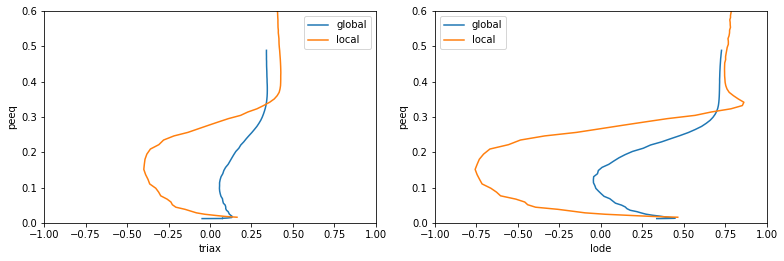

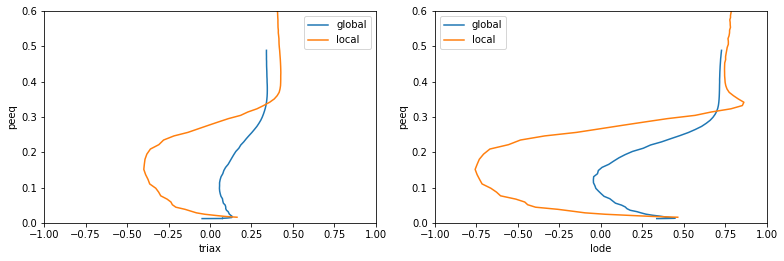

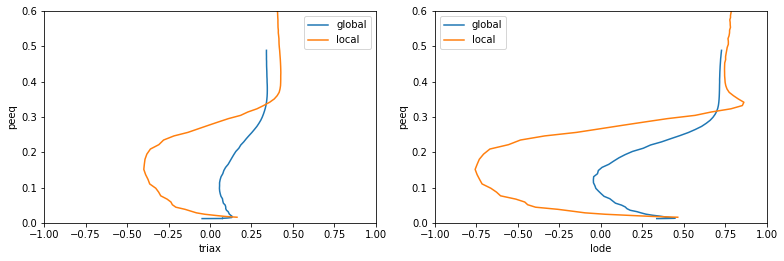

In [21]:
list_df_local_plot = []

for i in range(localPnt_no):
    df_local_plot = trimForPlot(df_local)
    list_df_local_plot.append(df_local_plot)
    
    graphPlot2D(df_global_plot, df_local_plot)

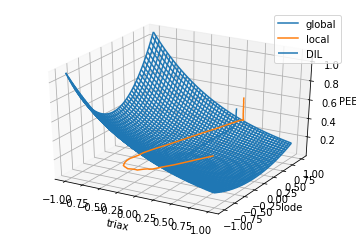

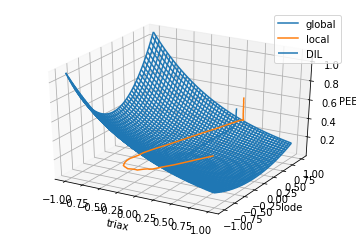

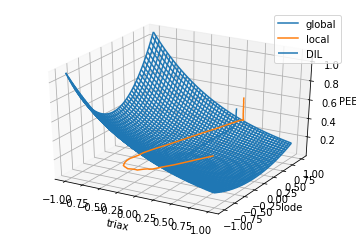

In [22]:
for i in range(localPnt_no):
    
    graphPlot3D(df_global_plot, list_df_local_plot[i])

,timeFrame,surfFac_pnt1,surfFac_pnt2,surfFac_pnt3
0,1,0.879576,0.803946,0.825410
1,2,0.881977,0.806141,0.827206
2,3,0.882094,0.806248,0.827316
3,4,0.882144,0.806294,0.827363
4,5,0.883103,0.807170,0.828262


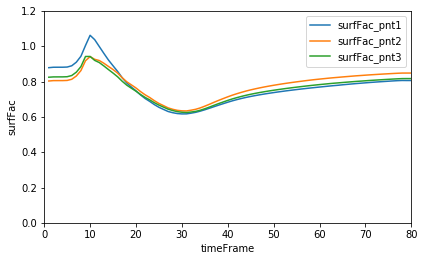

In [23]:
plot_size = (6, 4)
f, (ax) = plt.subplots(1, 1, figsize=plot_size)

for i in range(localPnt_no):
    columnName = 'surfFac_pnt'+str(i+1)
    surfFac = df_surfFac[columnName].values
    ax.plot(timeStep, surfFac, label=columnName)
    ax.set_xlim(0, timeStep_odb)
    ax.set_ylim(0, 1.2)
    ax.set(xlabel='timeFrame', ylabel='surfFac')
    ax.legend()

plt.tight_layout()
f.subplots_adjust(top=0.88)


df_surfFac.head()